## COMP 341: Practical Machine Learning
## Homework Assignment 4: Predicting List Prices for Houston Homes
### Due: Tuesday, October 18 at 11:59pm on Gradescope

Using the regression-based methods discussed in class, we will predict the list price of homes in the Houston area given attributes in existing listings on [Redfin](https://www.redfin.com) (an alternative to Zillow). Successful machine learning algorithms here can be used to assist real estate agents and prospective sellers in pricing their properties.



As always, fill in missing code following `# TODO:` comments or `####### YOUR CODE HERE ########` blocks and be sure to answer the short answer questions marked with `[WRITE YOUR ANSWER HERE]` in the text.

All code in this notebook will be run sequentially so make sure things work in order! Be sure to also use good coding practices (e.g., logical variable names, comments as needed, etc), and make plots that are clear and legible.

For this assignment, there will be **15 points** allocated for general coding points:
* **10 points** for coding style
* **5 points** for code flow (accurate results when everything is run sequentially)

### Part 0: Setup
First, we need to import some libraries that are necessary to complete the assignment.

In [ ]:
import pandas as pd
import numpy as np

Add additional modules/libraries to import here (rather than wherever you first use them below):

In [ ]:
# additional modules/libraries to import
from sklearn.model_selection import train_test_split
from plotnine import *
from sklearn.metrics import *
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

We provide some code to get the data file for this assignment into your workspace below. You only need to do the following 4 steps once:
1. Go to 'My Drive' in your own Google Drive
2. Make a new folder named `comp341`
3. Download the [training data](https://drive.google.com/file/d/1vh5o-kEN9qPKe5I0UCNQ_51ga_nNdWvU/view?usp=sharing) as well as the [test data](https://drive.google.com/file/d/1FK3mBkNWH1KL_KZrAEZ7QGUDxBcG77Bp/view?usp=sharing). You should now have a file entitled `houston_homes.csv` as well as a `houston_homes_test.csv` on your computer.
4. In the `comp341` folder you created in step 2, click `New -> File Upload` and select the two csv files from your computer.

Now, we will mount your local Google Drive in colab so that you can read the file in (you will need to do this each time your runtime restarts).

In [ ]:
# note that this command will trigger a request from google to allow colab
# to access your files: you will need to accept the terms in order to access
# the files this way
from google.colab import drive
drive.mount('/content/drive')

# if you followed the instructions above exactly, CVA.csv should be
# in comp341/; if your files are in a different directory
# on your Google Drive, you will need to change the path below accordingly
DATADIR = '/content/drive/My Drive/comp341/hw4/'

Mounted at /content/drive


Now that your Google Drive is mounted, you can read in the data in `houston_homes.csv` into a pandas DataFrame:

In [ ]:
df = pd.read_csv(DATADIR + "houston_homes.csv")

We have already held out a portion of the full dataset to be your test set (`houston_homes_test.csv`). In fact, the `list_price` in this test set is hidden so you will not know the true list prices of these homes. You will not need to use this data until Part 4 of the homework assignment, when you use your favorite models to make predictions for this set of homes and submit them to [our Kaggle competition](https://www.kaggle.com/t/ac92570fac5544898d23467424835035).

**Important note:** while the performance of your predictions will not be graded, a portion of your grade will be based off of whether you submitted predictions that can be evaluated by Kaggle (i.e., in the right format, passes basic checks)! As such, make sure to set up an account and try submitting predictions earlier rather than later.

For Parts 1-3, you will only use the data in `houston_homes.csv`. In Parts 1 and 2, you will partition this data into a training and validation set so that we can evaluate how well our models perform for model selection. In Part 3, you will use cross-validation to dive deeper for one of the models.

In [ ]:
# TODO: divide your data into a training and validation set using an 80/20 split

x = df.drop(['list_price', 'houseid'], axis=1)
y = df['list_price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=6)

### Part 1: Data exploration (30 pts)
As always, it is important to dive into the data to see what is going on. Let's start with the typical check for missing values.

In [ ]:
# TODO: check for missing values in the training data, make a table of NaN counts per feature
# include only features with non-zero missing value counts in your table

na = x_train.isna().sum().reset_index()
na.columns = ['feature', 'counts']
na.loc[na.counts > 0]

,feature,counts
4,beds,2
5,baths,9
6,location,4
7,sqft,16
8,lot_size,520
10,days_on_market,2
11,hoa,1640


**Short Answer Question:** Do you think that the missing values are going to be problematic for predicting list price? Why or why not?

`[WRITE YOUR ANSWER HERE]`

For the most part, the missing values are not going to be problematic because the amount of missing values for most features are small (2-16) compared to the amount of total observations. However, there are two features (lot_size and hoa) which has a lot of missing feature (520 and 1640 respectively) which could cause some problems.

We know that housing markets can be vastly different by region. This data is isolated to the Houston housing market, but even within Houston, there can be fluctuation between different neighborhoods. Let's take a deeper look at the region diversity in the data.

In [ ]:
# TODO: calculate how many houses are on the market per zipcode in your training data

zipcode = x_train.zipcode.value_counts().reset_index()
zipcode.columns = ['zipcode', 'counts']
zipcode

,zipcode,counts
0,77056,131
1,77007,129
2,77009,122
3,77008,119
4,77055,117
...,...,...
130,77502,1
131,77587,1
132,77505,1
133,77504,1


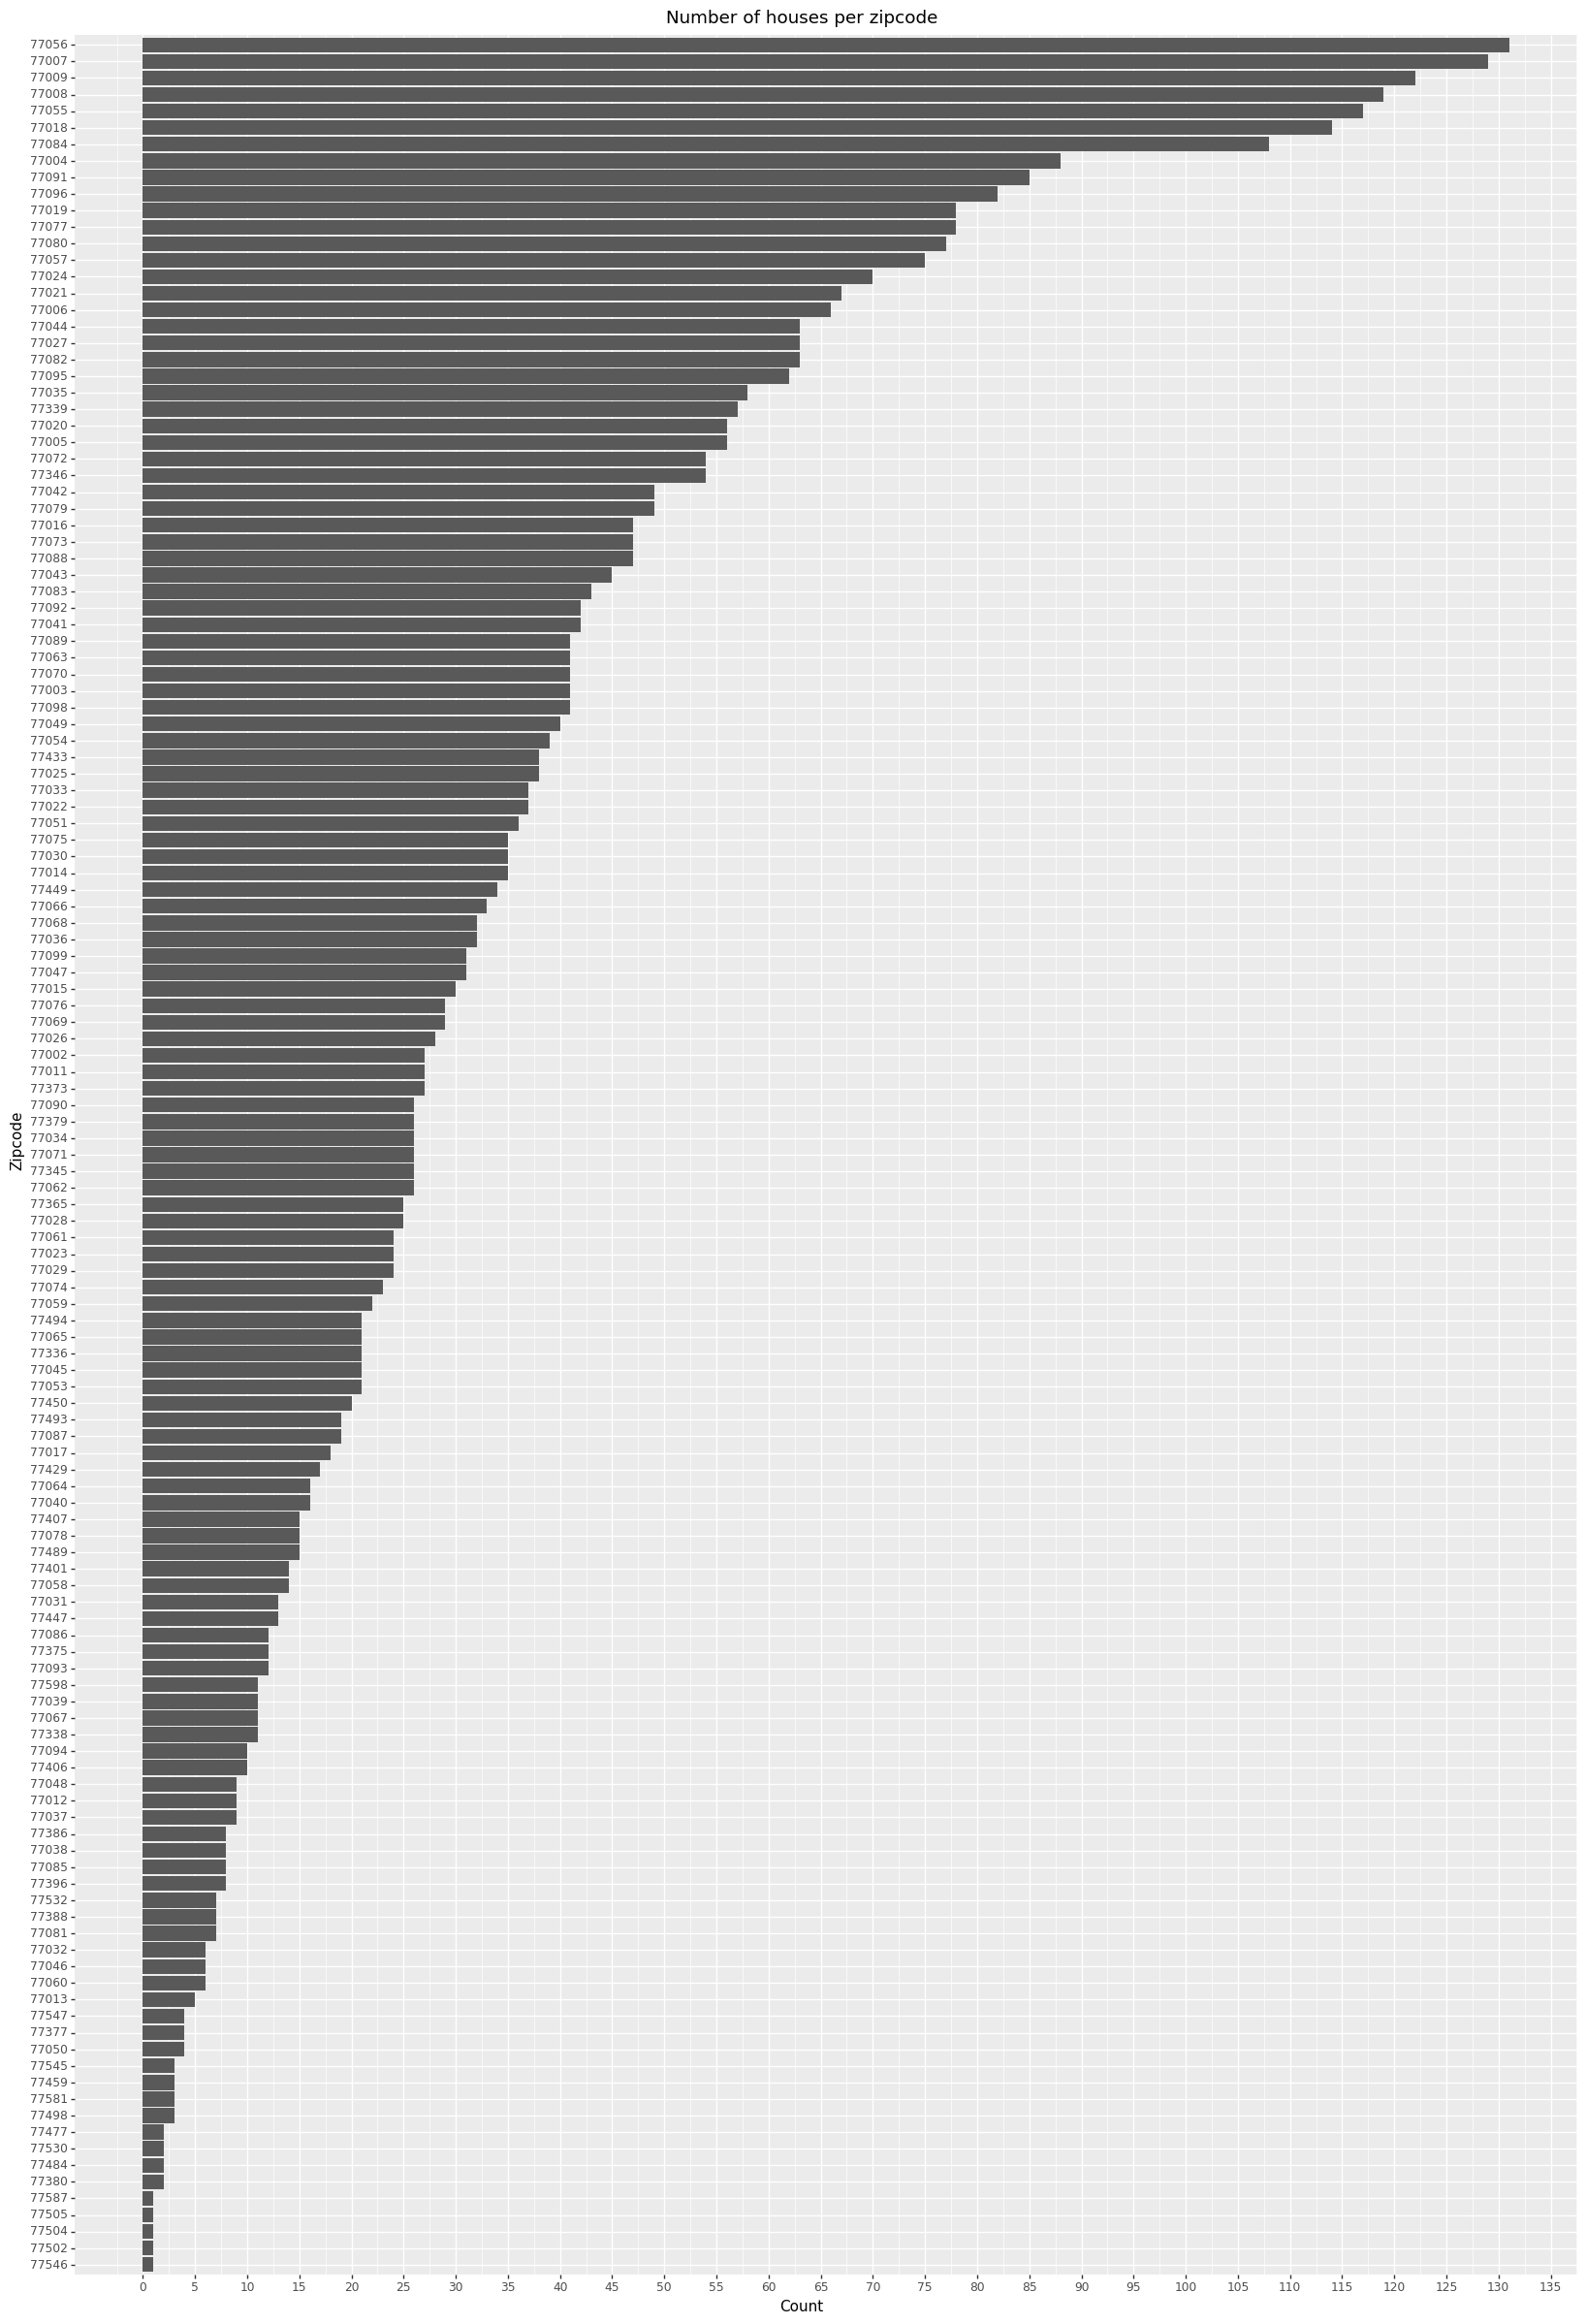

<ggplot: (8786761353185)>

In [ ]:
# TODO: plot the number of houses per zipcode in the training data
# sort the plot by the total number of houses per zipcode so that it is
# easy to see the zipcodes with the most/least houses for sale

zipcode_plot = zipcode.sort_values(by='counts')
zipcode_list = zipcode_plot['zipcode'].tolist()
zipcode_cat = pd.Categorical(zipcode_plot['zipcode'], categories=zipcode_list)

# assign to a new column in the DataFrame
zipcode.assign(zipcode_cat = zipcode_cat)

(ggplot(zipcode_plot)
 + aes(x='zipcode_cat', weight='counts')
 + geom_bar(size=20)
 + coord_flip()
 + scale_y_continuous(breaks = list(range(0, zipcode_plot.counts.max() + 5, 5)))
 + theme(figure_size=(20, 30))
 + labs(y='Count', x='Zipcode', title='Number of houses per zipcode')
)

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_density.py:153: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_density.py:155: PlotnineWarning: Groups with fewer than 2 data points have been removed.


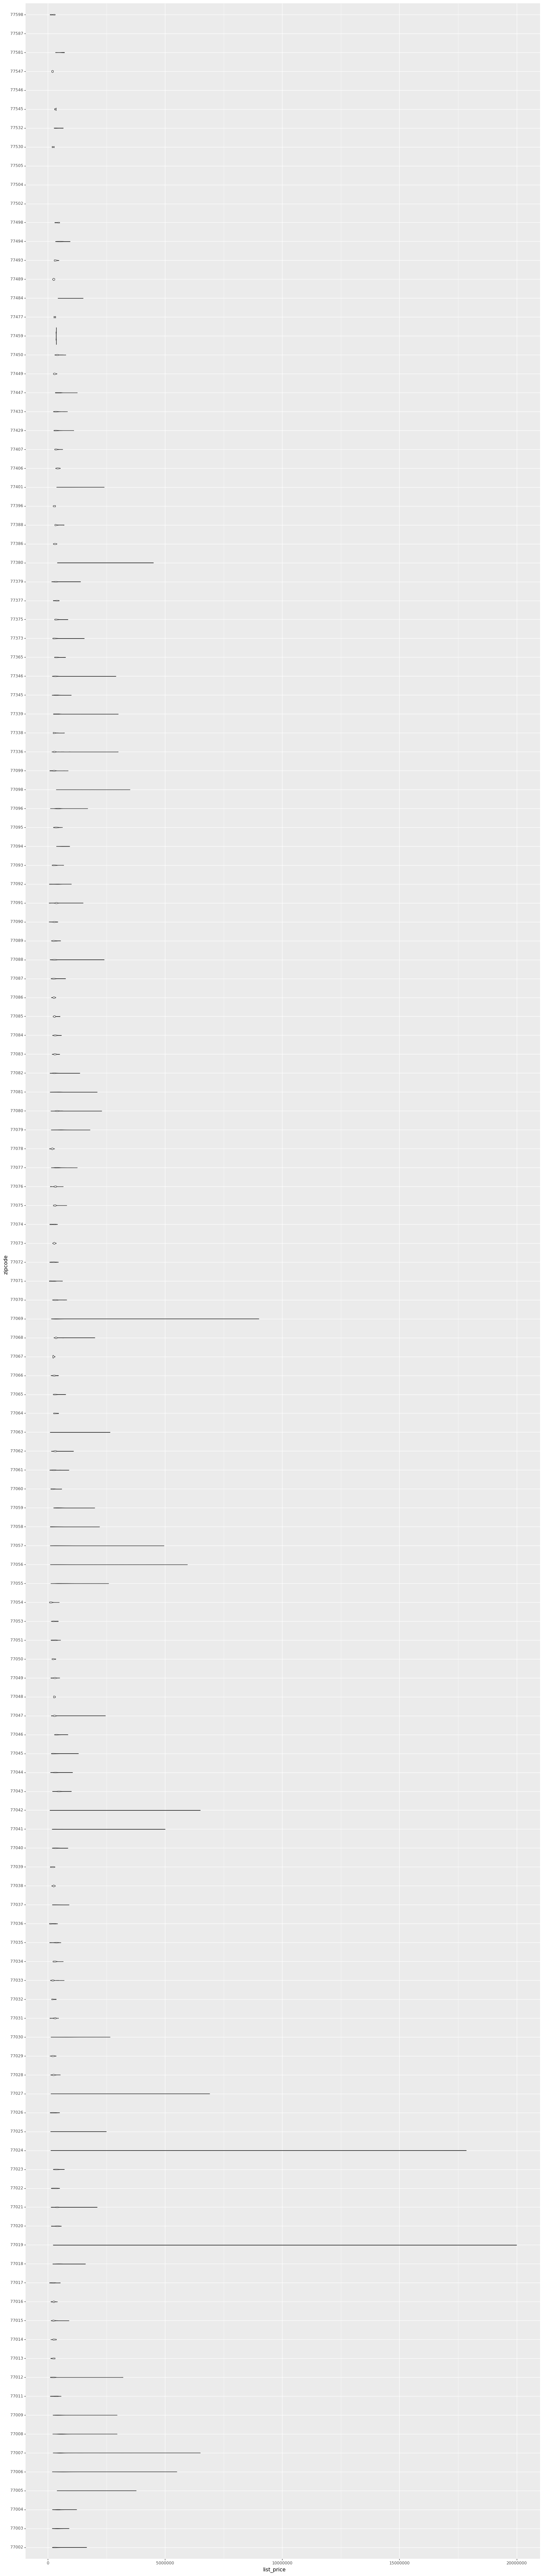

<ggplot: (8786759945829)>

In [ ]:
# TODO: using violin plots, plot the distribution of list prices per zipcode
# in your training data

violin = pd.concat([x_train, y_train], axis=1, join="inner")
violin = violin[['zipcode', 'list_price']]
violin['zipcode'] = violin['zipcode'].astype('category')

(ggplot(violin)
 + aes(x='zipcode', y='list_price')
 + geom_violin()
 + theme(figure_size=(20, 100))
 + coord_flip()
)

**Short Answer Question:** Based on the plots you generated above, do you think differences in zipcode distribution will affect models that predict list prices? Explain.

`[WRITE YOUR ANSWER HERE]`

Yes.

Zipcodes that have small amount of observations could also be less accurate than zipcodes that have a lot of observations in the training set.

In terms of the distribution of prices, zipcodes that have a wider range of prices might be less accurate at making predictions than those with a small distribution. However, zipcodes with small distributions might be less generalizable.

**Short Answer Question:** Where are the most expensive homes located?

`[WRITE YOUR ANSWER HERE]`

77019, 77024

Latitude and longitude can give an even more detailed view of what places are for sale across Houston. Let's map out where these properties are for sale and their list price.

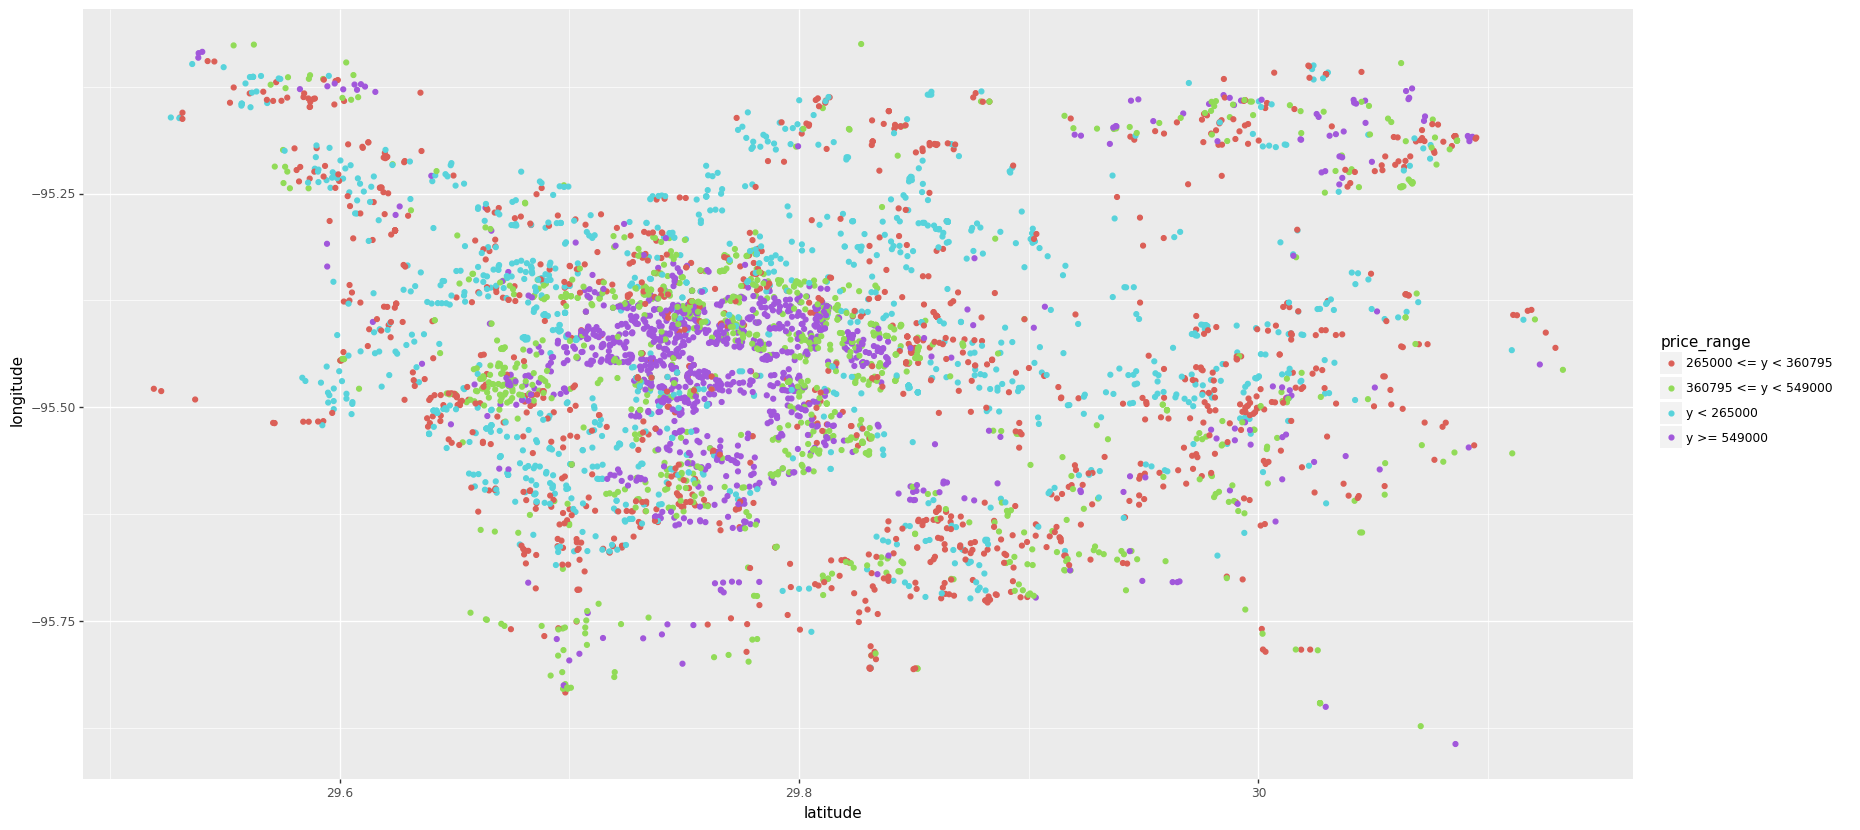

<ggplot: (8786760750393)>

In [ ]:
# TODO: Plot each property in the training data by the latitude and longitude,
# coloring points by their list price


def compute_price_range(row):
  q1 = 265000
  q2 = 360795
  q3 = 549000
  price = row.list_price
  if price < q1:
    row.price_range = "y < 265000"
  elif price >= q1 and price < q2:
    row.price_range = "265000 <= y < 360795"
  elif price >= q2 and price < q3:
    row.price_range = "360795 <= y < 549000"
  else:
    row.price_range = "y >= 549000"
  return row

# combined x_train and y_train
combined = pd.concat([x_train, y_train], axis=1, join="inner")

# calculate quantiles of list_price
quantiles = combined.list_price.quantile([0.25, 0.5, 0.75]).reset_index()
quantiles.columns = ['quantile', 'list_price']
quantiles = quantiles.list_price.tolist()

# label each observation with the list_price quantile range
combined['price_range'] = 0
combined = combined.apply(compute_price_range, axis='columns')

(ggplot(combined, aes(x='latitude', y='longitude', color='price_range'))
 + geom_point()
 + theme(figure_size=(20, 10))
)


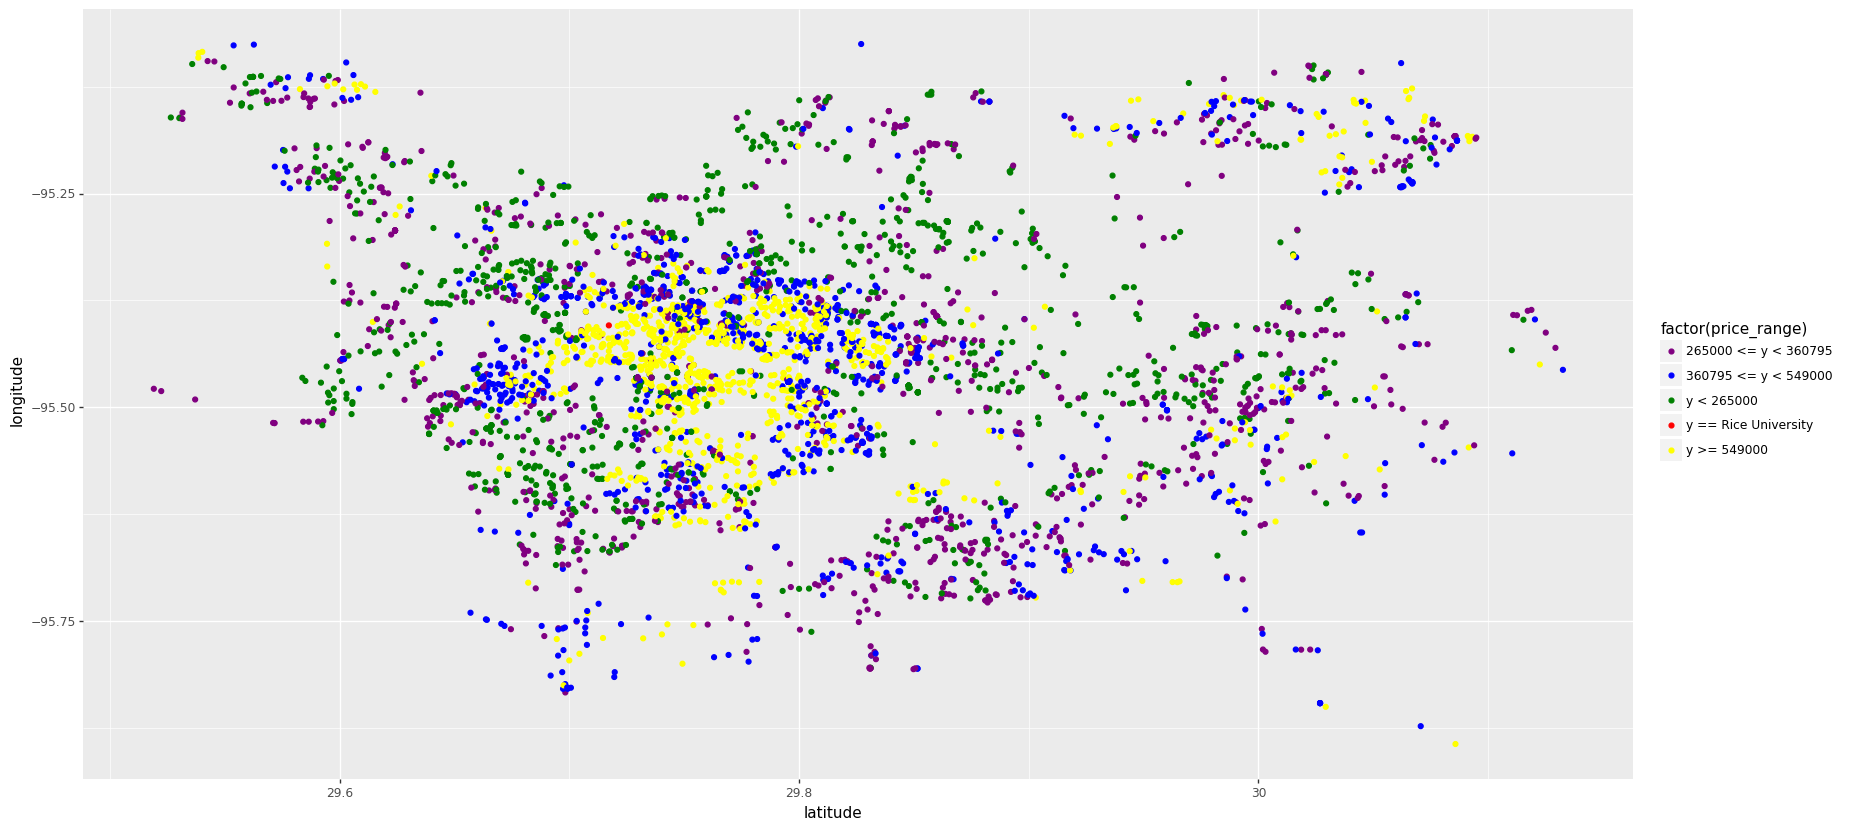

<ggplot: (8786765212861)>

In [ ]:
# EXTRA CREDIT (1pt): Make the same latitude and longitude plot as above but this time add
# a point for the location of Rice University, making sure that it is clearly visible

rice = {'latitude': 29.717154, 'longitude':-95.404182, 'price_range':"y == Rice University"}
combined = combined.append(rice, ignore_index=True)
(ggplot(combined, aes(x='latitude', y='longitude', color='factor(price_range)'))
 + geom_point()
 + scale_color_manual(values=["purple", 'blue', 'green', 'red', 'yellow'])
 + theme(figure_size=(20, 10))
)

**Short Answer Question:** Is latitude and longitude more / less / similarly informative than zipcode for determining list price? Explain.

`[WRITE YOUR ANSWER HERE]`

Latitude and longitude is more infomrative than zipcode because it allows us to easily see the clusters of homes with similar prices because we can see the area on the plot where points with the same colors are located, whereas with zipcodes, we can only see the distribution of prices within that zipcode area. It is less intuitive to compare two areas with zipcodes than with latitude and longitude.

Before we make our models, let's check to see if our features are related to each other and how closely they relate to the variable that we want to predict, `list_price`. One quick way to check for these relationships is to use correlation.

In [ ]:
# TODO: check the correlation between numeric features in the training data
combined = pd.concat([x_train, y_train], axis=1, join="inner")
combined.corr()

,zipcode,beds,baths,sqft,lot_size,year_built,days_on_market,hoa,latitude,longitude,list_price
zipcode,1.000000,0.170262,-0.006853,0.033049,0.013187,0.140462,-0.075011,-0.178681,0.345070,-0.160299,-0.088850
beds,0.170262,1.000000,0.613796,0.616785,-0.227209,0.144164,-0.011870,-0.303752,0.159164,-0.056394,0.330069
baths,-0.006853,0.613796,1.000000,0.819705,-0.103761,0.392004,0.064031,-0.002597,0.045661,-0.061352,0.629483
sqft,0.033049,0.616785,0.819705,1.000000,-0.057940,0.204216,0.085555,0.003093,0.070214,-0.074926,0.743864
lot_size,0.013187,-0.227209,-0.103761,-0.057940,1.000000,-0.078272,0.004276,0.480786,-0.066541,-0.023268,0.004860
year_built,0.140462,0.144164,0.392004,0.204216,-0.078272,1.000000,-0.042196,-0.040347,0.191750,-0.058416,0.092702
days_on_market,-0.075011,-0.011870,0.064031,0.085555,0.004276,-0.042196,1.000000,0.126285,-0.041123,0.030576,0.148501
hoa,-0.178681,-0.303752,-0.002597,0.003093,0.480786,-0.040347,0.126285,1.000000,-0.167747,0.029271,0.211322
latitude,0.345070,0.159164,0.045661,0.070214,-0.066541,0.191750,-0.041123,-0.167747,1.000000,-0.010464,-0.046307
longitude,-0.160299,-0.056394,-0.061352,-0.074926,-0.023268,-0.058416,0.030576,0.029271,-0.010464,1.000000,-0.018117


**Short Answer Question:** Based on the correlations, should we remove any features before running linear regression? Explain.

`[WRITE YOUR ANSWER HERE]`

Baths is highly correlated with bed (0.61), sqft and beds (0.62), sqft and baths (0.82), hoa and lot_size (0.48).

We should remove beds and baths because not only that they are highly correlated with each other, they are also both highly correlated with sqft. Hoa and lot_size are also relatively correlated, so we would also want to remove one of them. We want to remove highly correlated features because they are making the model more complicated while not adding much information.

Now that we have done some exploration of our data (we can always do more - feel free to do more if you wish!), we should think about how we will define "success" for this problem. One helpful way is to come up with a baseline heuristic that we should exceed with regression models.

**Short Answer Question:** If our goal is to reduce the error in our price predictions, design a baseline heuristic for this problem. Explain your rationale.

`[WRITE YOUR ANSWER HERE]`

From the correlation matrix above, sqft is the most correlated with list_price. So, based on this, we can say that houses with more sqft will be more expensive.

We can make predictions based on this heuristic by finding the average cost per sqft over all the houses. To make a prediction, we can multiply that number by the sqft of the house.

If sqft is missing then we can just take the mean of the predicted prices.

In [ ]:
# TODO: make "predictions" on your validation set using your baseline heuristic

tmp = y_train / x_train.sqft
mean_price_per_sqft = tmp.mean()

y_pred = x_test.sqft * mean_price_per_sqft
mean_pred = y_pred.mean()
y_pred = y_pred.fillna(mean_pred)

In [ ]:
# TODO: what is the RMSE and RMSLE of your baseline heuristic model?

print(mean_squared_error(y_test, y_pred, squared=False))
print(mean_squared_log_error(y_test, y_pred, squared=False))

469612.97251023044
0.4650141872088646


### Part 2: Regression Models + Evaluation (25 pts)
Now that we have done some of the initial data exploration and chosen at least one baseline heuristic, we are ready to build some different regression models to predict list price. In this section, we will try three different models.

This time, we have done minimal filtering from Redfin's data. Looking at the data and the features you calculated the correlations for, you should decide which features might be useful for your model, realizing that you might not want to include all of them. You may also need to transform / preprocess some of them before using in the various models. Also be sure whatever you do to your training data, you also do the same to the validation set (while minimizing potential data leakage!).

In [ ]:
# TODO: use explanatory features of your choice to build a linear regression model on the training data
# evaluate your model on the validation set by calculating RMSE
# (hint: think carefully about your choice of features, if you need to scale, impute, etc)

x_train = x_train.drop(columns=['beds', 'baths', 'hoa', 'state', 'location'])
x_test = x_test.drop(columns=['beds', 'baths', 'hoa', 'state', 'location'])

In [ ]:
# make zipcode a category type
x_train['zipcode'] = x_train['zipcode'].astype('category')
x_test['zipcode'] = x_test['zipcode'].astype('category')

In [ ]:
# one hot encode the categorical features
linear_x_train = x_train.drop(columns=['zipcode', 'property_type', 'city'])
linear_x_train = pd.concat([linear_x_train, pd.get_dummies(x_train[['zipcode', 'property_type', 'city']])], axis=1)

linear_x_test = x_test.drop(columns=['zipcode', 'property_type', 'city'])
linear_x_test = pd.concat([linear_x_test, pd.get_dummies(x_test[['zipcode', 'property_type', 'city']])], axis=1)


# drop uncommon columns
li1 = linear_x_train.columns.tolist()
li2 = linear_x_test.columns.tolist()

# uncommon_train = []
for col in li1:
  if col not in li2:
      linear_x_test[col] = 0

# uncommon_test = []
for col in li2:
  if col not in li1:
    linear_x_train[col] = 0

# knn impute the missing values
imputer = KNNImputer(n_neighbors=5)
imputer = imputer.fit(linear_x_train.values)

imp_x_train = imputer.transform(linear_x_train.values)
imp_x_train = pd.DataFrame(imp_x_train, columns = linear_x_train.columns, index = linear_x_train.index)

imp_x_test = imputer.transform(linear_x_test.values) # transform using fit from training set
imp_x_test = pd.DataFrame(imp_x_test, columns = linear_x_test.columns, index = linear_x_test.index)

In [ ]:
# scale all numeric (non-one-hot-encoded) columns
ct = make_column_transformer(
    (StandardScaler(), ['sqft', 'lot_size', 'year_built', 'days_on_market', 'latitude', 'longitude']),
    remainder="passthrough",
    verbose_feature_names_out=False
)

ct.fit(imp_x_train)
final_x_train = ct.transform(imp_x_train)
final_x_train = pd.DataFrame(data=final_x_train, columns=ct.get_feature_names_out())

final_x_test = ct.transform(imp_x_test)
final_x_test = pd.DataFrame(data=final_x_test, columns=ct.get_feature_names_out())

In [ ]:
def round_to_zero(pred):
  for i in range(len(pred)):
    if pred[i] < 0:
      pred[i] = 0

lr = LinearRegression()
lr.fit(final_x_train, y_train)
y_pred = lr.predict(final_x_test)
round_to_zero(y_pred)

print(mean_squared_error(y_test, y_pred, squared=False))

338204.8092552962


**Short Answer Question:** Which columns did you choose to omit from your feature set? Why did you exclude these columns?

`[WRITE YOUR ANSWER HERE]`

*   beds and baths because they are both relatively correlated with sqft
*   hoa because it is relatively correlated with lot_size and it also has a lot of missing values
*   state because it is all houston -> doesn't add anything
*   location because most of it is unique so it doesn't add much value



**Short Answer Question:** Does the linear regression model outperform the baseline heuristic you chose earlier? What does this comparison tell you?

`[WRITE YOUR ANSWER HERE]`

Yes, the RMSE for linear regression is lower than the baseline heuristic's. This means that taking more features into account - performing linear regression on explanatory data (after preprocessing) - is more effective than looking at one feature (sqft) using our baseline heuristic.

In [ ]:
# TODO: use explanatory features of your choice to build a lasso regression model on the training data
# this time, evaluate your model on the validation set data by calculating RMSLE

lasso = Lasso()
lasso = lasso.fit(final_x_train, y_train)

y_pred = lasso.predict(final_x_test)
round_to_zero(y_pred)
mean_squared_log_error(y_test, y_pred, squared=False)

3.499295526218069

Recall that Lasso regression has a hyperparameter alpha. Tuning alpha might increase the performance of our model versus using the default values. Below we examine the effect of this hyperparameter on the training and validation error.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.924e+14, tolerance: 3.427e+11 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


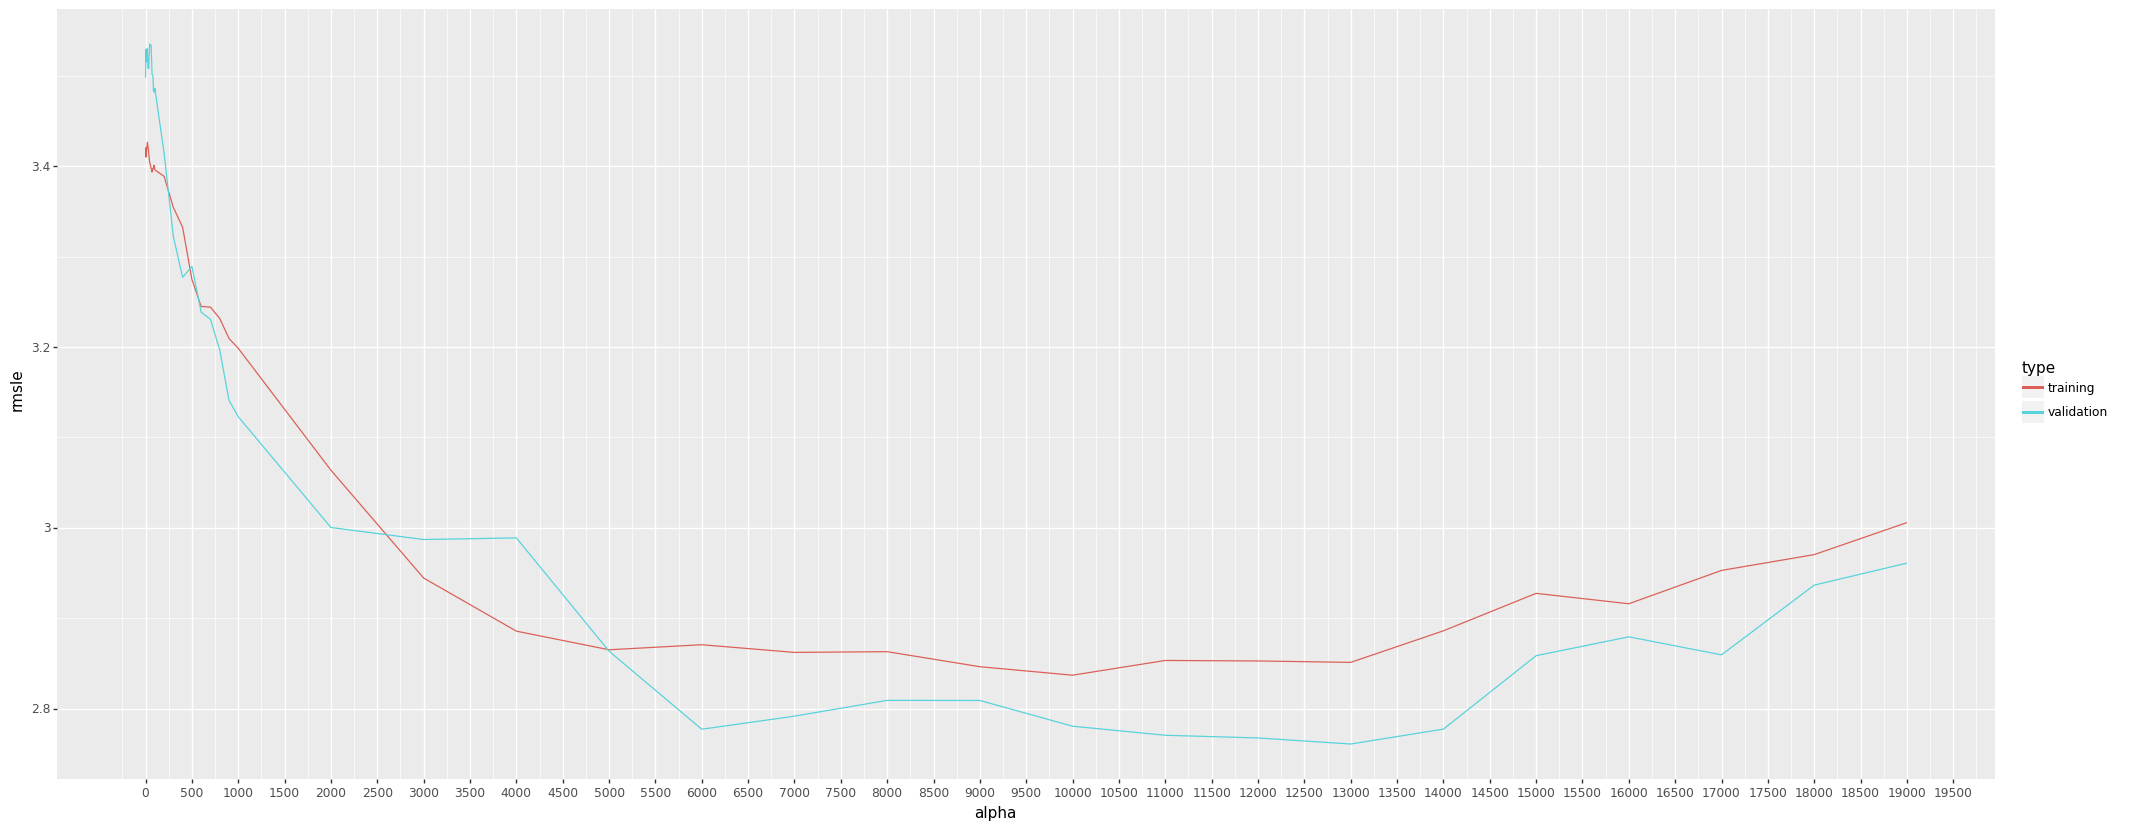

<ggplot: (8786761001713)>

In [ ]:
# TODO: we provide an initial set of alphas to explore (with variable increments from 0-20,000)
# plot both the training RMSLE and the validation RMSLE for a lasso regression model as alpha changes
# note that depending on what this initial set of alphas show you, you may want to focus on a smaller range
# or expand to look at even larger alphas
alphas = np.concatenate([np.arange(0,100,5), np.arange(100,1000,100), np.arange(1000,20000,1000)])

# alpha_vals = []
training = []
validation = []

# run predictions on training and testing data
for alpha_val in alphas:
  lasso = Lasso(alpha = alpha_val)
  lasso = lasso.fit(final_x_train, y_train)

  training_pred = lasso.predict(final_x_train)
  round_to_zero(training_pred)
  training_rmsle = mean_squared_log_error(y_train, training_pred, squared=False)
  training.append(training_rmsle)

  testing_pred = lasso.predict(final_x_test)
  round_to_zero(testing_pred)
  testing_rmsle = mean_squared_log_error(y_test, testing_pred, squared=False)
  validation.append(testing_rmsle)

# Create two dataframes and combine them
training_df = pd.DataFrame({'alpha':alphas, 'rmsle':training})
testing_df = pd.DataFrame({'alpha':alphas, 'rmsle':validation})

training_df['type'] = 'training'
testing_df['type'] = 'validation'

plot_df = pd.concat([training_df, testing_df])

# plot
(ggplot(plot_df, aes(x='alpha', y='rmsle', color='type'))
  + geom_line()
  + theme(figure_size=(25, 10))
  + scale_x_continuous(breaks= list(range(0, plot_df.alpha.max() + 1000, 500)))
)

In [ ]:
plot_df.loc[plot_df.rmsle == plot_df.rmsle.min()]

,alpha,rmsle,type
41,13000,2.760873,validation


**Short Answer Question:** Using the plot above as a guide, determine if there is an optimal alpha (or small range of alphas) for this task. Explain.

`[WRITE YOUR ANSWER HERE]`

alpha=13000 because it has the lowest rmsle on the validation set out of the alpha values.

In [ ]:
# TODO: using SVR, explore the RMSLE of these 3 kernels: 'linear', 'poly', and 'rbf' with C=100
# output a table with the train and validation RMSLE for these 3 kernels
# note: though there are only 3 variants, you should still avoid repeating code
# (i.e., use a for loop or other iterable)

train_rmsle = []
test_rmsle = []
kernels = ['linear', 'poly', 'rbf']

for kernel_val in kernels:
  svr = SVR(C=100, kernel=kernel_val)
  svr = svr.fit(final_x_train, y_train)
  train_pred = svr.predict(final_x_train)
  test_pred = svr.predict(final_x_test)

  round_to_zero(train_pred)
  round_to_zero(test_pred)

  training_rmsle = mean_squared_log_error(y_train, train_pred, squared=False)
  testing_rmsle = mean_squared_log_error(y_test, test_pred, squared=False)

  train_rmsle.append(training_rmsle)
  test_rmsle.append(testing_rmsle)

svr_df = pd.DataFrame({'kernel':kernels, 'train_rmsle':train_rmsle, 'test_rmsle':test_rmsle})
svr_df

,kernel,train_rmsle,test_rmsle
0,linear,0.536789,0.477865
1,poly,0.693059,0.643158
2,rbf,0.695667,0.657984


**Short Answer Question:** Which SVR kernel has the best performance? Give some intuition as to why you think it outperformed the other kernel choices.

`[WRITE YOUR ANSWER HERE]`

Linear SVR kernel performs the best because it has the lowest rmsle. This could possibly be because the data is linear; there are linear correlations between features and the list_price.

### Part 3: Cross-validation (25 pts)
So far, we have been running all of our analysis using a train-validation split of 80/20 and choosing our parameters based on the performance across this train-validation split, but this might not be as generalizable and robust. Instead of tuning our hyperparameters on this specific partition, let's try using cross-validation.

The next few questions will use decision tree regressor models and explore the effect of max_depth on validation error.


In [ ]:
# TODO: Calculate the mean RMSLE using 5-fold cross-validation (CV) for a decision
# tree regressor model with max_depth from 1-50 (in increments of 1).
# Save these values for plotting later.

max_depth = []
rmsle = []

x = pd.concat([final_x_train, final_x_test])
y = pd.concat([y_train, y_test])

for max_depth_val in range(1, 51):
  dt_reg = DecisionTreeRegressor(max_depth=max_depth_val)
  cv_scores = cross_val_score(dt_reg, x, y, cv=5, scoring='neg_mean_squared_log_error')
  max_depth.append(max_depth_val)
  rmsle.append(cv_scores)

cv_df = pd.DataFrame({'max_depth':max_depth, 'neg_rmsle':rmsle})

def mean_rmsle(row):
  scores = row.neg_rmsle
  mean_neg = scores.mean()
  mean = -mean_neg
  row.rmsle = mean
  return row

cv_df['rmsle'] = 0
cv_df = cv_df.apply(mean_rmsle, axis='columns')
cv_df = cv_df.drop(columns=['neg_rmsle'])
cv_df['type'] = 'cv'
print(cv_df.loc[cv_df.rmsle == cv_df.rmsle.min()])
cv_df

    max_depth     rmsle type
15         16  0.102829   cv


,max_depth,rmsle,type
0,1,0.504028,cv
1,2,0.347916,cv
2,3,0.265098,cv
3,4,0.226279,cv
4,5,0.187208,cv
5,6,0.169216,cv
6,7,0.151419,cv
7,8,0.137067,cv
8,9,0.123580,cv
9,10,0.122128,cv


**Short Answer Question:** Based on these RMSLEs, which max_depth parameter is optimal? Explain.

`[WRITE YOUR ANSWER HERE]`

max_depth of around 15 is the best because it has the lowest rmsle.

In [ ]:
# TODO: Build a decision tree regessor model with max_depth from 1-50 (in increments of 1)
# on the training data without using CV.
# Calculate the RMSLE for the training set and the validation set that you have been using
# in the earlier parts of the assignment. Save these values for plotting later.

max_depth = []
train_rmsle = []
test_rmsle = []

for max_depth_val in range(1, 51):
  dt_reg = DecisionTreeRegressor(max_depth=max_depth_val)
  dt_reg = dt_reg.fit(final_x_train, y_train)

  y_train_pred = dt_reg.predict(final_x_train)
  y_test_pred = dt_reg.predict(final_x_test)

  training_rmsle = mean_squared_log_error(y_train, y_train_pred, squared=False)
  testing_rmsle = mean_squared_log_error(y_test, y_test_pred, squared=False)

  max_depth.append(max_depth_val)
  train_rmsle.append(training_rmsle)
  test_rmsle.append(testing_rmsle)

train_df = pd.DataFrame({'max_depth':max_depth, 'rmsle':train_rmsle})
test_df = pd.DataFrame({'max_depth':max_depth, 'rmsle':test_rmsle})

train_df['type'] = 'training'
test_df['type'] = 'validation'

dt_df = pd.concat([train_df, test_df])
dt_df

,max_depth,rmsle,type
0,1,0.712907,training
1,2,0.587844,training
2,3,0.508008,training
3,4,0.458426,training
4,5,0.430311,training
...,...,...,...
45,46,0.340260,validation
46,47,0.345658,validation
47,48,0.328694,validation
48,49,0.324571,validation


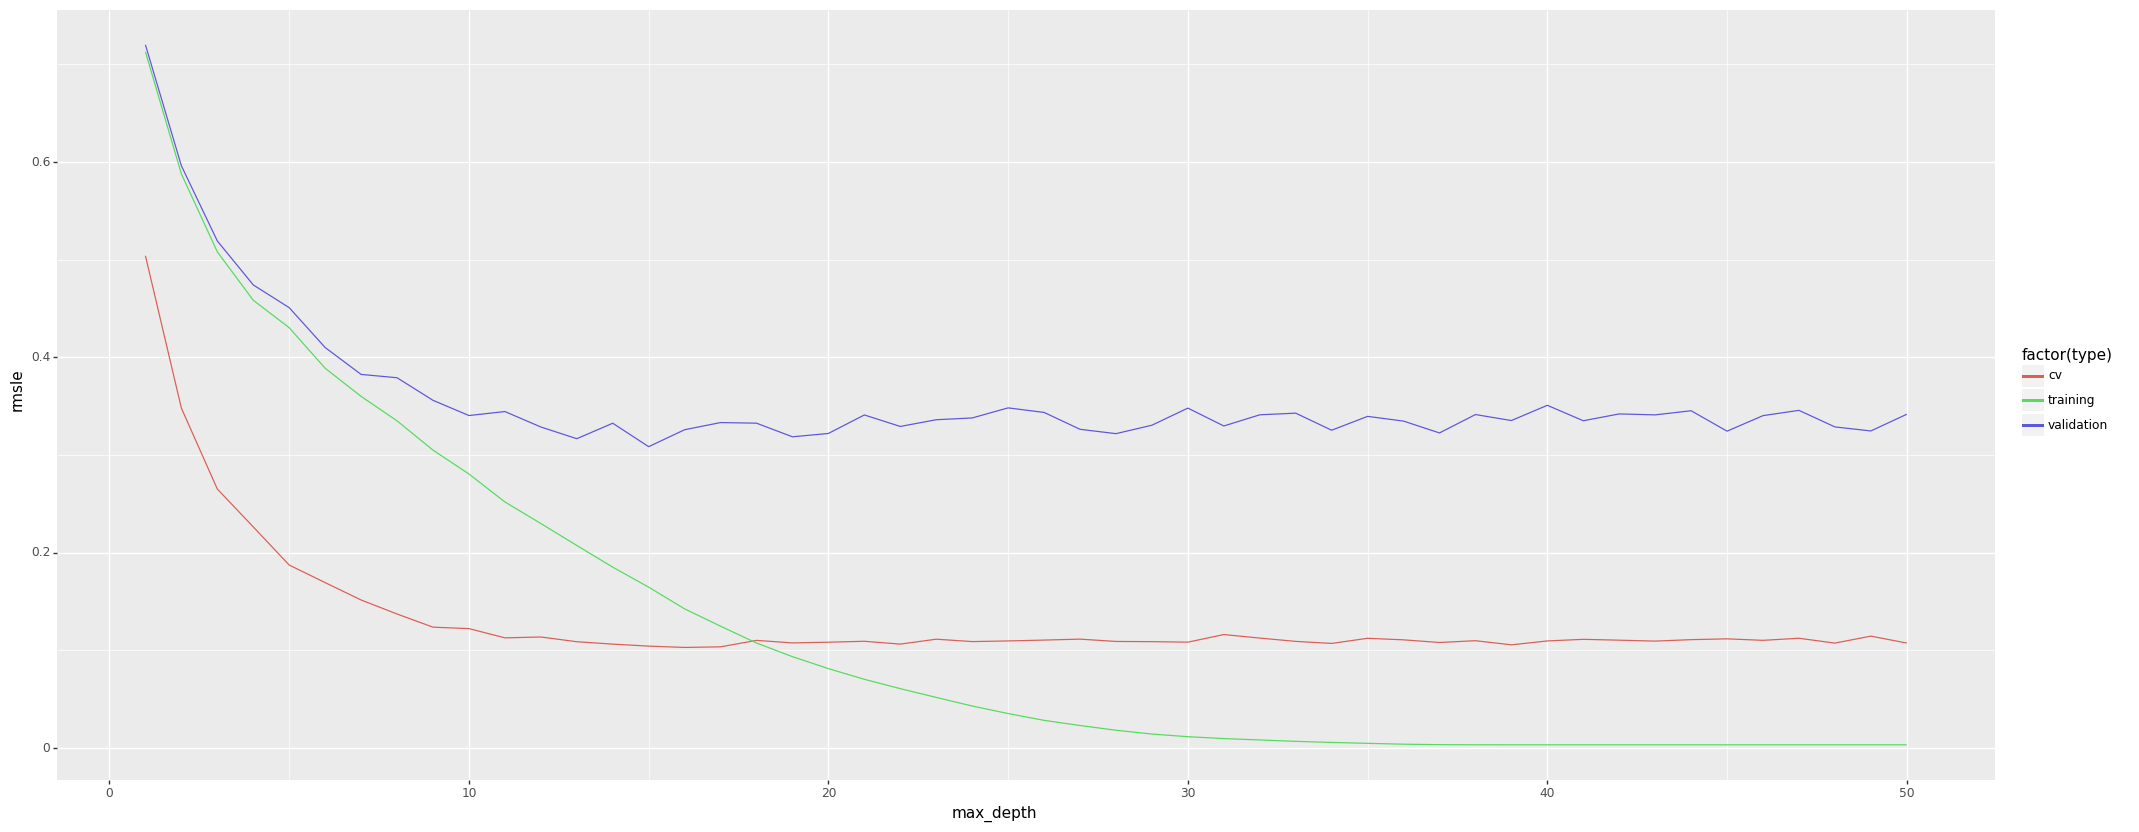

<ggplot: (8786765212745)>

In [ ]:
# TODO: In the same figure, plot the mean RMSLE from CV, as well as training RMSLE and validation RMSLE from above
# as max tree depth varies (1 to 50).

dt_df = pd.concat([dt_df, cv_df])

(ggplot(dt_df, aes(x='max_depth', y='rmsle', color='factor(type)'))
 + geom_line()
 + theme(figure_size=(25, 10))
)

In [ ]:
cv = dt_df.loc[dt_df.type == 'cv']
cv.loc[cv.rmsle == cv.rmsle.min()]

,max_depth,rmsle,type
15,16,0.102829,cv


**Short Answer Question:** Was cross-validation helpful in choosing the optimal max depth parameter? Why or why not?


`[WRITE YOUR ANSWER HERE]`


Yes, because from the plot, although the rmsle from cv and validation set has similar shape, the plot for cv is smoother, making it easier to examine the the change in rmsle as max_depth increases. Therefore, cv makes it easier to examine where the minimum rmsle is.

### Part 4: Compete! (5 pts, with up to 10 extra credit pts)
Now, we can put our favorite models (or try additional variations!) to the test using the data that we haven't looked at in any part of the assignment (`houston_homes_test.csv`).

Here, we will be using [Kaggle](https://www.kaggle.com/t/ac92570fac5544898d23467424835035). If you do not already have a Kaggle account, you will need to make one.

There are additional details on the Kaggle site, but some particularly important notes:
* You are free to choose any team name (the name that will show up on the Kaggle leaderboard) as long as it is not inappropriate or offensive; however, in order to receive credit, you **must** specify your `team name` in your notebook here. If you do not, there is no way for us to assign you credit!
* Kaggle lists the close date as several days after the homework's due date. This is because Kaggle does not support late submissions. The homework and your submission on Kaggle are due by the due date listed here, but you may use late days and turn it in late (i.e., if you submit Kaggle predictions after the due date, it will automatically count towards your late days even if you have turned in your notebook already).
* This portion of the assignment **must** be completed independently. You cannot share prediction code or predictions with each other. In fact, you must put the exact code you use for your final predictions below. Violations will result in point deductions.
* Related, you cannot modify your prediction files manually. Violations will result in point deductions.
* You can only use regression models that we have discussed in class (though you can feel free to preprocess your data / tune any of the parameters in the models however you like)!

For this homework, you will simply be graded for completion of a successful submission to Kaggle, and not on performance! But for fun, we have included several benchmarks on the Kaggle leaderboard, based on either simple heuristics or models.

You can receive extra credit points for exceeding these benchmarks on the private leaderboard:
* 1 pt for passing the `base-benchmark`
* 1 pt for passing the `easy-benchmark`
* 1 pt for passing the `medium-benchmark`
* 1 pt for passing the `hard-benchmark`

And additional points for doing well on the private leaderboard that will be revealed after the late due date (if there are ties, everyone tied will receive the same number of points):
* 6 pts for 1st place
* 4 pts for 2nd place
* 2 pts for 3rd place


**Kaggle team name:** Pete Sirithanachai

Now, we will finally read in the test dataset.

In [ ]:
df_test = pd.read_csv(DATADIR + "houston_homes_test.csv")
df_test

,houseid,property_type,city,state,zipcode,beds,baths,location,sqft,lot_size,year_built,days_on_market,hoa,latitude,longitude
0,0,Condo/Co-op,Houston,TX,77057,2,2.0,St Clair Condo,1452.0,NaN,1981,114,1301.0,29.754564,-95.478979
1,7,Single Family Residential,Houston,TX,77009,3,2.5,Irvington,2096.0,6500.0,1948,86,NaN,29.803962,-95.367365
2,19,Single Family Residential,Houston,TX,77345,4,3.5,Greentree Village Sec 05,3282.0,8712.0,1989,86,32.0,30.070582,-95.179686
3,21,Condo/Co-op,Houston,TX,77024,2,2.0,Memorial,1599.0,NaN,1981,81,1135.0,29.778931,-95.468689
4,24,Single Family Residential,Houston,TX,77045,3,2.5,Antigua,1746.0,2415.0,2022,114,83.0,29.643475,-95.425377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,7414,Single Family Residential,Houston,TX,77083,3,2.0,Mission Bend Sec 10,2426.0,11375.0,1980,57,NaN,29.708884,-95.658674
1855,7420,Single Family Residential,Houston,TX,77095,4,2.5,Wheatstone Village Cloverfield,2145.0,10375.0,1985,38,67.0,29.896001,-95.660277
1856,7421,Single Family Residential,Porter,TX,77365,4,3.5,Kingwood Royal Brook,2548.0,NaN,2022,37,100.0,30.086500,-95.188000
1857,7429,Single Family Residential,Spring,TX,77379,4,3.5,Gleannloch Farms Sec 40,3827.0,9827.0,2006,47,83.0,30.052937,-95.573522


In [ ]:
# TODO: put all code needed (including preprocessing steps) to make your
# final kaggle submission; note that this code must match the predictions
# that you provide on kaggle

df = pd.read_csv(DATADIR + "houston_homes.csv")
x_train = df.drop(['list_price', 'houseid'], axis=1)
y_train = df['list_price']

x_test = df_test.drop(['houseid'], axis=1)

x_train = x_train.drop(columns=['beds', 'baths', 'hoa', 'state', 'location'])
x_test = x_test.drop(columns=['beds', 'baths', 'hoa', 'state', 'location'])

# make zipcode a category type
x_train['zipcode'] = x_train['zipcode'].astype('category')
x_test['zipcode'] = x_test['zipcode'].astype('category')

# one hot encode the categorical features
linear_x_train = x_train.drop(columns=['zipcode', 'property_type', 'city'])
linear_x_train = pd.concat([linear_x_train, pd.get_dummies(x_train[['zipcode', 'property_type', 'city']])], axis=1)

linear_x_test = x_test.drop(columns=['zipcode', 'property_type', 'city'])
linear_x_test = pd.concat([linear_x_test, pd.get_dummies(x_test[['zipcode', 'property_type', 'city']])], axis=1)


# drop uncommon columns
li1 = linear_x_train.columns.tolist()
li2 = linear_x_test.columns.tolist()

# uncommon_train = []
for col in li1:
  if col not in li2:
      linear_x_test[col] = 0

# uncommon_test = []
for col in li2:
  if col not in li1:
    linear_x_train[col] = 0

# knn impute the missing values
imputer = KNNImputer(n_neighbors=5)
imputer = imputer.fit(linear_x_train.values)

imp_x_train = imputer.transform(linear_x_train.values)
imp_x_train = pd.DataFrame(imp_x_train, columns = linear_x_train.columns, index = linear_x_train.index)

imp_x_test = imputer.transform(linear_x_test.values) # transform using fit from training set
imp_x_test = pd.DataFrame(imp_x_test, columns = linear_x_test.columns, index = linear_x_test.index)

# scale all numeric (non-one-hot-encoded) columns
ct = make_column_transformer(
    (StandardScaler(), ['sqft', 'lot_size', 'year_built', 'days_on_market', 'latitude', 'longitude']),
    remainder="passthrough",
    verbose_feature_names_out=False
)

# use decision tree regression model
ct.fit(imp_x_train)
final_x_train = ct.transform(imp_x_train)
final_x_train = pd.DataFrame(data=final_x_train, columns=ct.get_feature_names_out())

final_x_test = ct.transform(imp_x_test)
final_x_test = pd.DataFrame(data=final_x_test, columns=ct.get_feature_names_out())

dt_reg = DecisionTreeRegressor(max_depth=17)
dt_reg = dt_reg.fit(final_x_train, y_train)

y_pred_kagg = dt_reg.predict(final_x_test)
len(y_pred_kagg)

1859

You can see details about the file format for submission on kaggle (`sample_submission.csv`, essentially a 2 column file with `houseid`, the unique identifier in your test set, and `list_price`, your predictions). To make things easier, we provide here some sample code that you can modify to make your own submission file if your predictions were in a variable called `y_pred_kagg`.

In [ ]:
results = pd.Series(y_pred_kagg.flatten(), name="list_price")
results = pd.concat([df_test['houseid'], results], axis=1)
results.to_csv('my_submission.csv', index=False)

Once you output your csv file, you need to download the file from colab to your local computer (you can click the file folder icon on the left panel to see the files in your workspace) and upload that file to the Kaggle site as your submission. Note that you can submit multiple times (up to 5 times a day)!

## To Submit
Download the notebook from Colab as a `.ipynb` notebook (`File > Download > Download .ipynb`) and upload it to the corresponding Gradescope assignment. Your assignment should be named `comp341-hw4.ipynb`.  

Also, double check that your Kaggle submission shows up on the public leaderboard.